![image](../pic/pic1.jpg)
![image](../pic/pic2.jpg)

Длинные названия потому, что за жизненным циклом обектов следить не умею :)

In [1]:
Generate_Network_t0 <- function(size = 40, sparsity = 0.7) {
	network <- matrix(0, nrow=size, ncol=size)
  
	for (i in 1:size) {
		for (j in 1:size) {
			if (runif(1) > sparsity) {
				network[i, j] <- 1
			}
		}
	}
  
	return(network)
}


Network_function_1 <- function(i, Network) { # outdegree (density)
	net <- sum(Network[i, ])
	return(net)
}


Network_function_2 <- function(i, Network) { # recip
	net <- 0
    for(j in 1:length(Network[1,])){
        if(i != j){
            net <- net + Network[i,j]*Network[j,i]
        }
    }
	return(net)
}

Network_function_3 <- function(i, Network) { # transitive triplets (transTrip)
	net <- 0
	for (j in 1:length(Network[i, ])) {
		for(h in 1:length(Network[, j])){
			if(i!=j & j!=h & i!=h){
                
				net <- net + (Network[i,j] * Network[i,h] * Network[h,j]) 
			}
		}
	}
	return(net)
}

Generate_Possible_Ministep_Matrix_vector <- function(i, Network) {
	Networks <- list()
  
	for (j in 1:length(Network[i, ])) {
		if (i != j) {
			TMP_Net <- Network
            if ( TMP_Net[i, j] == 0){ TMP_Net[i, j] <- 1 }
			else if ( TMP_Net[i, j] == 1){ TMP_Net[i, j] <- 0 }
			Networks[[j]] <- TMP_Net    
		}
        else{
            Networks[[j]] <- Network
        }
        
	}
	return(Networks)
}




Distribution_actors <- function(i, Network, beta, Possible_Ministep_Matrix_vector) {
	Util <- numeric(length(Network[i, ]))
	total_util <- 0
  
	for (h in 1:length(Network[i, ])) {
		total_util <- total_util + exp(Utility(Network, beta, i, h, Possible_Ministep_Matrix_vector))
	}


    
	Util_j <- numeric(length(Network[i, ]))

	for (j in 1:length(Network[i, ])) {
			Util_j[j] <- exp(Utility(Network, beta, i, j, Possible_Ministep_Matrix_vector))
			Util[j] <- Util_j[j] / total_util
	}
    
	return(Util)
}

Utility <- function(Network, beta, i, j, Possible_Ministep_Matrix_vector) {
    NetIJ <- Possible_Ministep_Matrix_vector
	util <- (beta[1] * Network_function_1(i, NetIJ[[j]])) + (beta[2] * Network_function_2(i, NetIJ[[j]])) #+ (beta[3] * Network_function_3(i, NetIJ[[j]]))
	return(util)
}

Simulator <- function(Network0, t = 0, LambdaV, total_Lambda, T, beta) {
	Network <- Network0 
	while (t < T) {
		deltaT <- rexp(1, rate=total_Lambda)
        
		# i <- sample(1:length(Network0[1,]), size=1, prob=(LambdaV / total_Lambda))
        i <- sample(1:length(Network0[1,]), size=1)

        Possible_Ministep_Matrix_vector <- Generate_Possible_Ministep_Matrix_vector(i, Network)
		prob_vector <- 0
        
		prob_vector <- Distribution_actors(i, Network, beta, Possible_Ministep_Matrix_vector)
        
		j <- sample(1:length(Network0[i, ]), size=1, prob=prob_vector)

        if (j != i ){
            if ( Network[i, j] == 0){ Network[i, j] <- 1 }
    		else if ( Network[i, j] == 1){ Network[i, j] <- 0 }    
        }
        
		t <- t + deltaT
	}
	return(Network)
}

In [2]:
size <- 10
Network0 <- Generate_Network_t0(size = size, sparsity = .75)
LambdaV <- rep(.8, size)
total_Lambda <- sum(LambdaV)
# beta <- rexp(n = 2)
beta <- c(1.5, 1.8, 2.5)
T <- 2.5

In [3]:
Network1 <- Simulator(Network0, t = 2.5, LambdaV, total_Lambda, 5, beta)

In [4]:
Network2 <- Simulator(Network1, t = 5, LambdaV, total_Lambda, 7.5, beta)

In [5]:
sum(Network0)
sum(Network1)
sum(Network2)

[1] 30

[1] 42

[1] 63

In [6]:
rownames(Network0) <- LETTERS[1:10]
colnames(Network0) <- LETTERS[1:10]

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


---
# Проверка в RSiena

In [6]:
library(RSiena)

In [7]:
Networks <- array(c(Network0, Network1, Network2), dim = c(size, size, 3))

Networks <- sienaDependent(Networks, nodeSet="Actors",  allowOnly=FALSE) 
# Networks <- sienaDependent(Networks, nodeSet="Actors")

Networks

Type         oneMode             
Observations 3                   
Nodeset      Actors (50 elements)


In [8]:
mydata <- sienaDataCreate(Networks)
myeff <- getEffects(mydata)
mydata

Dependent variables:  Networks 
Number of observations: 3 

Nodeset                  Actors 
Number of nodes              50 

Dependent variable Networks     
Type               oneMode      
Observations       3            
Nodeset            Actors       
Densities          0.26 0.3 0.34


In [9]:
effectsDocumentation(myeff,type = "html", display = FALSE)

Effects documentation written to file myeff.html .


In [10]:
myeff <- includeEffects(myeff, recip , include = TRUE)
# myeff <- includeEffects(myeff, recip  , type = "creation", include = TRUE)
# myeff <- includeEffects(myeff, recip  , type = "eval", include = FALSE)

myeff <- includeEffects(myeff, density , include = TRUE)

# myeff <- includeEffects(myeff, transTrip, type = "creation", include = TRUE)
# myeff <- includeEffects(myeff, transTrip, include = TRUE)

  effectName  include fix   test  initialValue parm
1 reciprocity TRUE    FALSE FALSE          0   0   
  effectName          include fix   test  initialValue parm
1 outdegree (density) TRUE    FALSE FALSE    0.50907   0   


In [11]:
summary(myeff)

,name,effectName,functionName,shortName,interaction1,interaction2,type,basicRate,include,randomEffects,⋯,effect3,interactionType,local,setting,effectFn,statisticFn,netType,groupName,group,effectNumber
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,⋯,<int>,<chr>,<lgl>,<chr>,<list>,<list>,<chr>,<chr>,<dbl>,<int>
Networks.rate.1,Networks,constant Networks rate (period 1),Amount of network change in period 1,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,1
Networks.rate.2,Networks,constant Networks rate (period 2),Amount of network change in period 2,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,2
Networks.obj.eval.1,Networks,outdegree (density),Number of ties,density,,,eval,FALSE,TRUE,TRUE,⋯,0,dyadic,TRUE,,NULL,NULL,oneMode,Group1,1,12
Networks.obj.eval.2,Networks,reciprocity,Number of reciprocated ties,recip,,,eval,FALSE,TRUE,FALSE,⋯,0,dyadic,TRUE,,NULL,NULL,oneMode,Group1,1,15


In [12]:
myalgorithm <- sienaAlgorithmCreate(projname = 'Тест симулятора сети')
ans <- siena07( myalgorithm, data = mydata,silent = TRUE ,effects = myeff,batch = TRUE, clusterType="FORK", useCluster=TRUE, nbrNodes=12)

If you use this algorithm object, siena07 will create/use an output file Тест симулятора сети.txt .


In [13]:
ans

Estimates, standard errors and convergence t-ratios

                                   Estimate   Standard   Convergence 
                                                Error      t-ratio   

Rate parameters: 
  0.1      Rate parameter period 1 2.0698   ( 0.2043   )             
  0.2      Rate parameter period 2 1.9234   ( 0.1982   )             

Other parameters: 
  1.  eval outdegree (density)     1.5684   ( 0.5166   )    0.0071   
  2.  eval reciprocity             1.8362   ( 0.1541   )   -0.0102   

Overall maximum convergence ratio:    0.0132 


Total of 1977 iteration steps.


In [14]:
ans$theta

[1] 1.568438 1.836237

---


# Отсюда можно запускать. Будут прочитаны файлы из репозитория. 

**Что в моем случае есть rate?**
Скриптом `../data/main.r` запустил несколько повторов. Графики сходимости .

beta - мои параметры. 
- beta1 - density
- beta2 - transTrip

teta - оцененые параметры

rate - оцененая скорость
- rate1 - 1 период
- rate2 - 2 период

`?` - суммарная интенсивность всех акторов (задана)

In [15]:
# beta <- read.table("../data/beta.txt", sep = " ")
rate <- read.table("../data/rate.txt", sep = " ")
teta <- read.table("../data/teta.txt", sep = " ")
# total_Lambda <- read.table("../data/totalLambda.txt", sep = " ")
# lambda_mean_V <- read.table("../data/lambda_meam.txt", sep = " ")
# teta2 <- read.table("../data/teta2.txt", sep = " ")

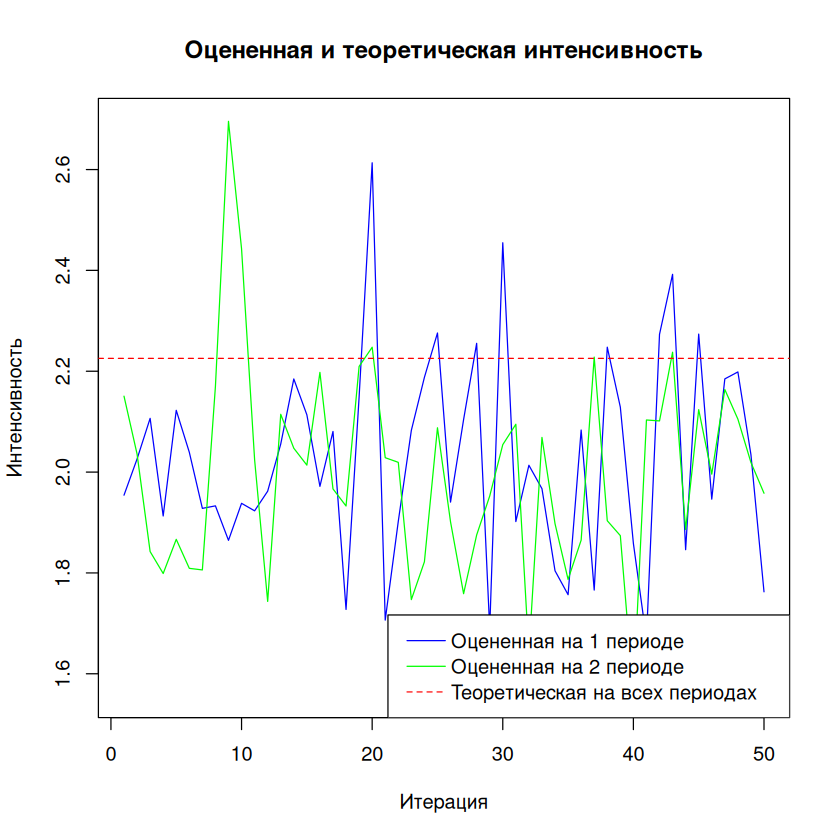

In [16]:
min_y <- min(min(rate$V1), min(rate$V2))
max_y <- max(max(rate$V1), max(rate$V2))

plot(rate$V1, type = "l", col = "blue", ylim = c(min_y, max_y), 
     xlab = "Итерация", ylab = "Интенсивность", main = "Оцененная и теоретическая интенсивность")
teor <- exp(total_Lambda/size)
lines(rate$V2, type = "l", col = "green")
abline(h = teor, col = "red", lty = 2)

lines(teor, type = "l", col = "red", lty = 2)

legend("bottomright", legend = c("Оцененная на 1 периоде", "Оцененная на 2 периоде", "Теоретическая на всех периодах"),
       col = c("blue", "green", "red"), lty = c(1, 1, 2), x.intersp = .3)

In [17]:
LambdaV[1]
total_Lambda/size

mean(rate$V2)

[1] 0.8

[1] 0.8

[1] 1.999509

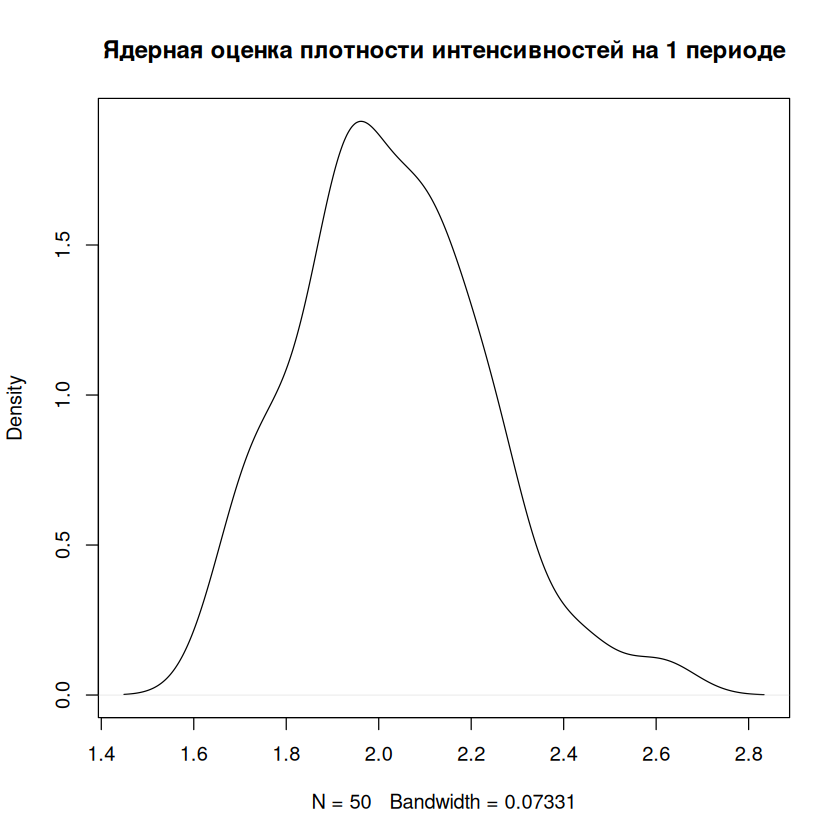

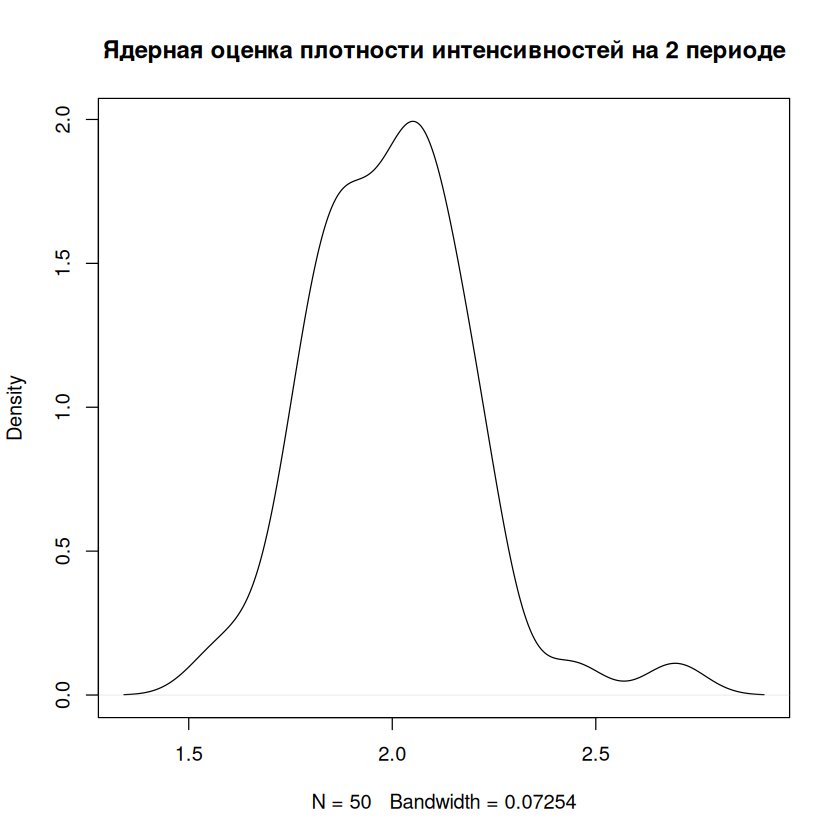

In [18]:
plot(density(rate$V1), main = "Ядерная оценка плотности интенсивностей на 1 периоде")
plot(density(rate$V2), main = "Ядерная оценка плотности интенсивностей на 2 периоде")

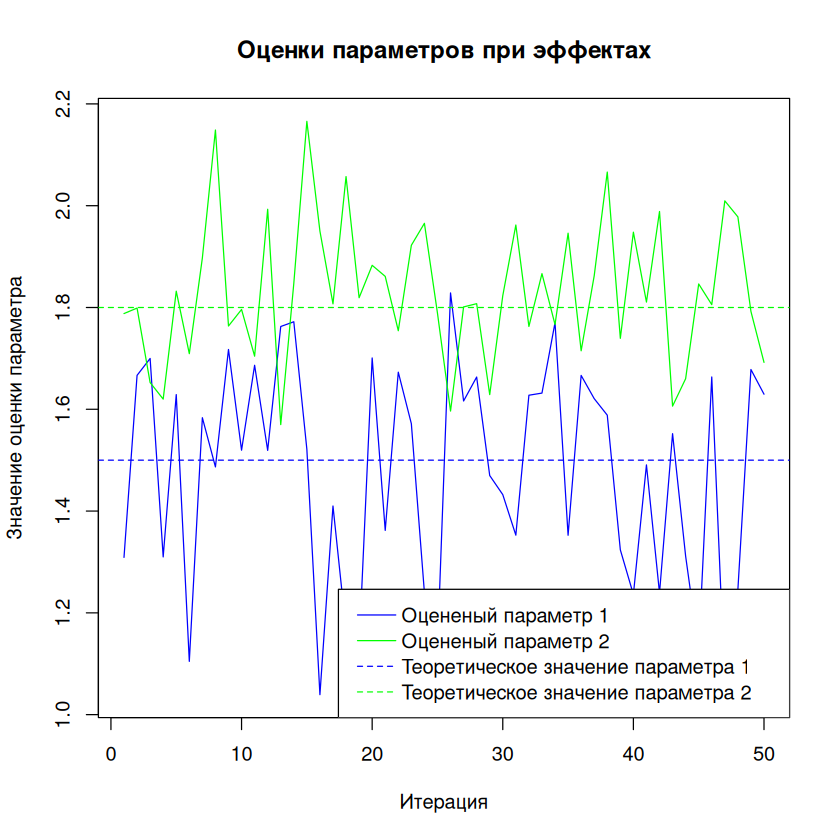

In [19]:
y_min <- min(c(teta$V1, teta$V2, beta[1], beta[2]))
y_max <- max(c(teta$V1, teta$V2, beta[1], beta[2]))

# Строим график с учетом диапазона
plot(teta$V1, type="l", col="blue", main = "Оценки параметров при эффектах", xlab = "Итерация", ylab = "Значение оценки параметра", ylim = c(y_min, y_max))
abline(h = beta[1], col = "blue", lty = 2)
abline(h = beta[2], col = "green", lty = 2)
lines(teta$V2, col = "green")

legend("bottomright", legend = c("Оцененый параметр 1", "Оцененый параметр 2", "Теоретическое значение параметра 1", "Теоретическое значение параметра 2"),
       col = c("blue", "green", "blue", "green"), lty = c(1, 1, 2, 2), x.intersp = .3)

In [37]:
mean(teta$V1)
mean(teta$V2)

var(teta$V1)
var(teta$V2)


[1] 1.477729

[1] 1.831491

[1] 0.04743431

[1] 0.01920937

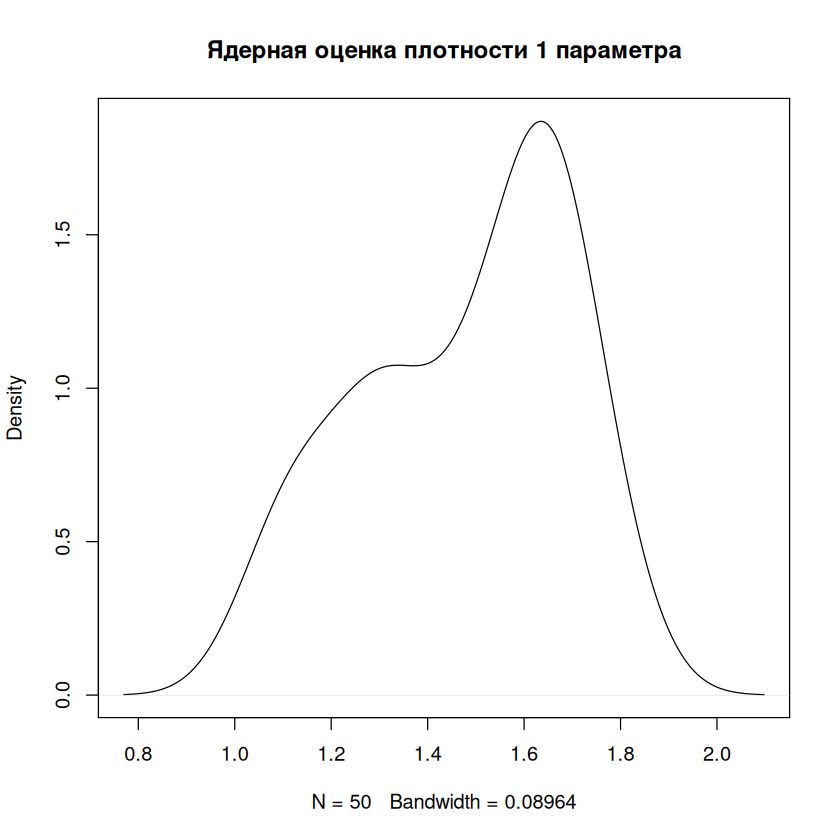

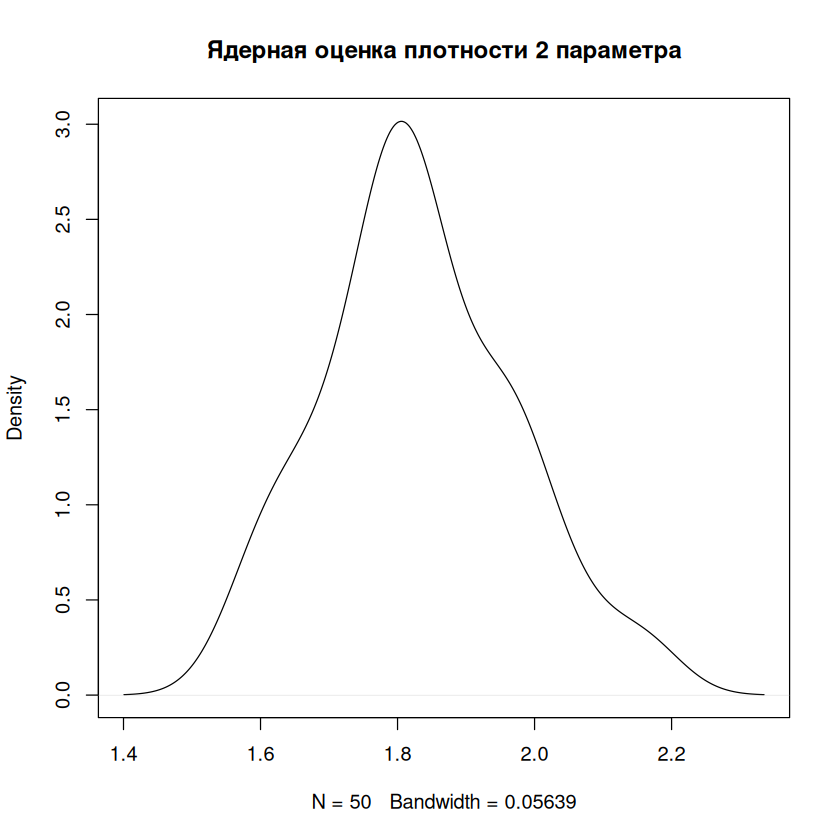

In [21]:
plot(density(teta$V1), main = "Ядерная оценка плотности 1 параметра")
plot(density(teta$V2), main = "Ядерная оценка плотности 2 параметра")

# Сохранение сети для Gephi

In [22]:
rownames(Network0) <- LETTERS[1:50]
colnames(Network0) <- LETTERS[1:50]
Net_df <- as.data.frame(Network0)
Net_df <- cbind(RowNames = rownames(Net_df), Net_df)
write.csv(Net_df, file = "Net0.csv", row.names = FALSE, sep = ";")

Warning message in write.csv(Net_df, file = "Net0.csv", row.names = FALSE, sep = ";"):
“attempt to set 'sep' ignored”


In [23]:
rownames(Network1) <- LETTERS[1:50]
colnames(Network1) <- LETTERS[1:50]
Net_df <- as.data.frame(Network1)
Net_df <- cbind(RowNames = rownames(Net_df), Net_df)
write.csv(Net_df, file = "Net1.csv", row.names = FALSE, sep = ";")

Warning message in write.csv(Net_df, file = "Net1.csv", row.names = FALSE, sep = ";"):
“attempt to set 'sep' ignored”


In [24]:
rownames(Network2) <- LETTERS[1:50]
colnames(Network2) <- LETTERS[1:50]
Net_df <- as.data.frame(Network2)
Net_df <- cbind(RowNames = rownames(Net_df), Net_df)
write.csv(Net_df, file = "Net2.csv", row.names = FALSE, sep = ";")

Warning message in write.csv(Net_df, file = "Net2.csv", row.names = FALSE, sep = ";"):
“attempt to set 'sep' ignored”


In [25]:
observations <- teta$V1
empirical_variance <- var(observations)

In [26]:
theoretical_variance <- pi^2 / 6

In [27]:
f_test_result <- var.test(observations, y = rnorm(length(observations), mean = mean(observations), sd = sqrt(theoretical_variance)))


In [28]:
f_test_result 


	F test to compare two variances

data:  observations and rnorm(length(observations), mean = mean(observations), sd = sqrt(theoretical_variance))
F = 0.029285, num df = 49, denom df = 49, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.01661871 0.05160621
sample estimates:
ratio of variances 
         0.0292853 


In [29]:
library(evd)



# Применение теста Колмогорова-Смирнова
ks_test_result <- ks.test(observations, "pgumbel", loc = 0, scale = 1)

# Результаты теста
print(ks_test_result)



	Exact one-sample Kolmogorov-Smirnov test

data:  observations
D = 0.70208, p-value = 8.882e-16
alternative hypothesis: two-sided

